# Exercise 2 - CNNs, ResNets and LR-Scheduling

 * Deep Learning for Computer Vision – Winter Term 2024/25
 * Lecture by: Constantin Pape
 * Tutors: Anwai Archit, Oleg Bakumenko, Luca Freckmann, Marei Freitag, Sarah Muth, Sushmita Nair
 * Due date: **Tuesday, Nov 19, before 10:00**

### Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics

In this exercise sheet, you will:
- work again with CIFAR-10
- implement a 1-layer CNN
- compare MLP and CNN
- vary architecture to improve model performance
- implement a ResNet for CIFAR-10
- learn about learning rate scheduling

*We are looking forward to seeing your solutions! Have fun!*

## IMPORTANT SUBMISSION INSTRUCTIONS

- **You need to answer all questions in written form!**
- When you've completed the exercise, download the notebook and rename it to `<surname1>_<surname2>_<surname3>.ipynb`
- Only submit the Jupyter Notebook (.ipynb file). No other file is required.
    - Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 2` -> `Tutorial X` (where, X is the tutorial you are assigned to).
- Make only one submission of the exercise per group.
- The deadline is strict.
- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand

Implementation:
- Do not change the cells which are marked as `DO NOT CHANGE`, similarly write your solution into the cells marked with TODOs for the questions asked.

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time
import pathlib

## 1. Setup

You can use the functions to grab the data, split the sets, create the dataloaders and plot results, etc. given to you at exercise sheet 1.

It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.

If you work with Kaggle (recommended) you have to mount the drive first and create a path to your python module or download the file from your drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('/content/drive/MyDrive/DeepLearning')

#### **TODO**
Create a file named `setup.py` with all the necessary functions. Download this file to your Kaggle workspace and import it on this notebook.

Hint: Use the package `gdown` to download files from google drive.

```python
!conda install -y gdown
!gdown <file_id>
```

Here's how to find the `file_id`:
If the file URL is https://drive.google.com/file/d/1066jDUxp8fXwdcNGj8h0CWJA0KNLpvKk/view?usp=share_link

where, `file_id` is 2732jDmxp7fXwddNGj8h0CWJA0WWLpvKk

In [ ]:
# TODO: Download setup.py from google drive in Kaggle

In [5]:
# TODO: Import setup.py
import my_setup

## 2. Load dataset, create dataloader, etc.

#### **TODO**
Call the functions of `setup.py` to instantiate the train-, test- and validation datasets along with their dataloaders.

In [6]:
# TODO: Define device
from my_setup import (
    get_device,
    grab_data,
    imshow,
    generate_train_val_data_split,
    init_data_loaders,
    accuracy,
    train,
    validate,
    run_training,
    plot,
    MLP,
    EarlyStopper
)

In [ ]:
device = get_device()
# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla T4
2 CPUs available


In [ ]:
# Download data
data_dir = pathlib.Path("data/")
cifar = torchvision.datasets.CIFAR10(data_dir, train=True, download=True)

Files already downloaded and verified


In [7]:
# TODO: Grab data, generate split and initialize data loaders
import os
# Define data directory and batch size
data_dir = pathlib.Path("data/")
batch_size = 256

# Grab CIFAR-10 dataset and compute normalization values
trainset, testset, dataset_mean, dataset_std = grab_data(data_dir)

# Split trainset into training and validation sets
trainset, valset = generate_train_val_data_split(trainset)

# Initialize DataLoaders
train_loader, val_loader, test_loader = init_data_loaders(trainset, valset, testset, batch_size)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#### **TODO**
Define the loss function. We use the cross entropy loss again.

In [8]:
# TODO: Define loss function
loss_function = nn.CrossEntropyLoss()

## 3. Simple 1-layer CNN model

### **TODO**
- Define the model.

The first step to training a model is defining its architecture.
Define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

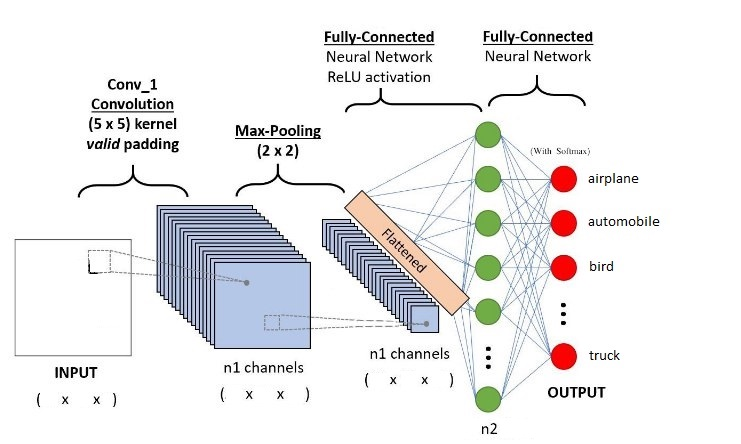

#### **Questions**

- What are the input dimensions?
   $$(N,3,32,32)$$
- What are the dimensions of the feature maps?
    
  Output Size= $$(W−K+2P)/S​+1$$
  (32-5+2*2)/1 + 1 = (32,32,32)
- What are the dimensions after pooling?
  $$(32,16,16)$$
- What is the size of each input (i.e value of `in_features`) to the first fully connected linear layer?
  $$32*16*16 = 8192$$
- What is the number of parameters for conv_1?
  $$Total Parameters=(Kernel Height×Kernel Width×Input Channels+Bias)×Output Channels$$
  $$(32*32*3+1)*32 = 2432$$

**Your answers here**

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2)  # Default stride is kernel_size (2)
        self.fc1 = nn.Linear(32 * 16 * 16, 512)  # CIFAR-10 input size = 32x32
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Convolution -> ReLU -> MaxPooling
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))  # Fully connected layer with ReLU
        x = self.fc2(x)  # Fully connected layer (output = 10 classes)
        return x

model = SimpleCNN()


In [ ]:
from torchsummary import summary

model = SimpleCNN().to("cuda")  # Move model to CPU
summary(model, input_size=(3, 32, 32))  # CIFAR-10 input size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Linear-3                  [-1, 512]       4,194,816
            Linear-4                   [-1, 10]           5,130
Total params: 4,202,378
Trainable params: 4,202,378
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.32
Params size (MB): 16.03
Estimated Total Size (MB): 16.36
----------------------------------------------------------------


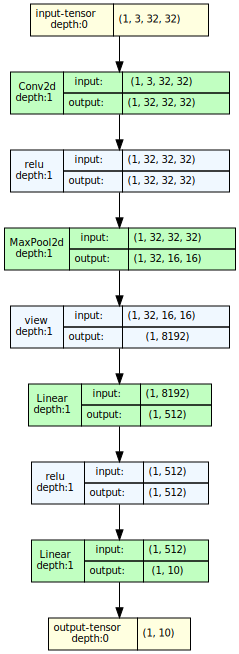

In [ ]:
# !pip install torchview  # Install if not already installed

from torchview import draw_graph

# Generate model architecture visualization
model_graph = draw_graph(model, input_size=(1, 3, 32, 32), device="cpu")
model_graph.visual_graph

#### **TODO**

- Train the model for 10 epochs. Try lr=0.001 (can be changed to suit other design choices you make)
- Plot the results of accuracy and loss as you did in exercise sheet 1.

In [ ]:
# TODO: Train and plot
model = SimpleCNN().to(device)  # Move model to GPU if available

# Define optimizer and loss function
lr = 0.0001  # Learning rate
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train the model for 10 epochs
num_epochs = 10
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
    model, optimizer, loss_function, device, num_epochs, train_loader, val_loader, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


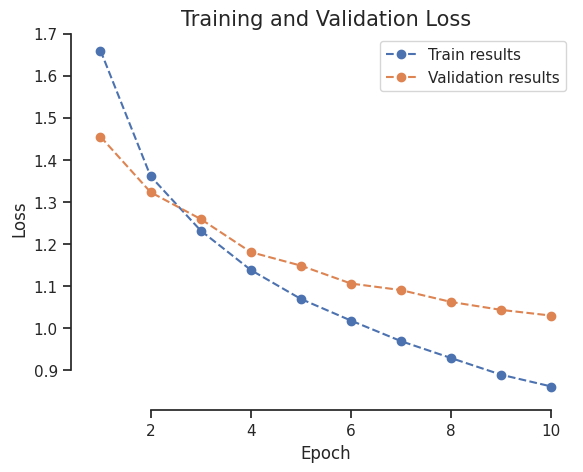

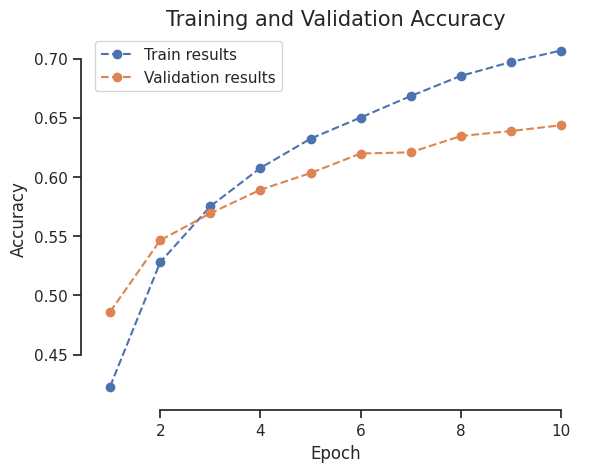

In [ ]:
# Plot learning and accuracy curves
my_setup.plot(
    title="Training and Validation Loss",
    label="Loss",
    train_results=train_losses,
    val_results=val_losses,
    yscale='linear')

my_setup.plot(
    title="Training and Validation Accuracy",
    label="Accuracy",
    train_results=train_accs,
    val_results=val_accs,
    yscale='linear')


#### **TODO**
Compare results to the MLP models you trained in Exercise 1. What can you observe?

**Your answers here**
- From MLP models: Train loss: 1.55, Val loss: 1.57, Train acc: 0.454, Val acc: 0.442, lr=0.0001
- From 1-layer CNN model: Train loss: 0.86, val loss: 1.03, train acc: 0.707, val acc 0.644, lr=0.0001


**For your reference, below is the loss and accuracy plots of an MLP model trained in Exercise sheet 1:**

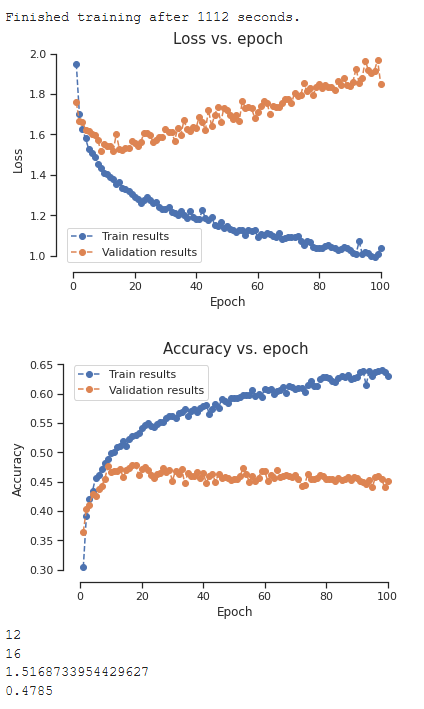

#### **TODO**
Train longer (ca. 60 epochs), plot again.

In [ ]:
# TODO: Train and plot
model = SimpleCNN().to(device)  # Move model to GPU if available

# Define optimizer and loss function
lr = 0.001  # Learning rate
optimizer = optim.Adam(model.parameters(), lr=lr)

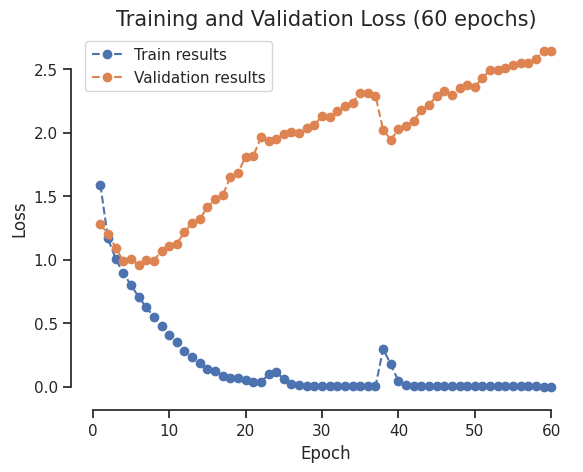

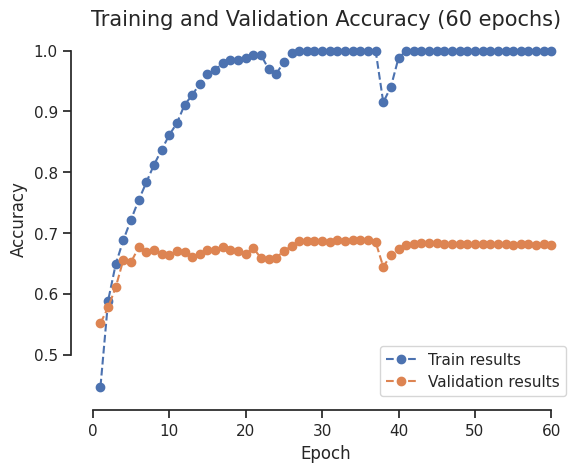

In [ ]:
# TODO: Train and plot
# Train the model for 60 epochs
num_epochs = 60
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
    model, optimizer, loss_function, device, num_epochs, train_loader, val_loader, verbose=True)

# Plot learning and accuracy curves
my_setup.plot(
    title="Training and Validation Loss (60 epochs)",
    label="Loss",
    train_results=train_losses,
    val_results=val_losses,
    yscale='linear')

my_setup.plot(
    title="Training and Validation Accuracy (60 epochs)",
    label="Accuracy",
    train_results=train_accs,
    val_results=val_accs,
    yscale='linear')


#### **Questions**
- Why is that not an optimal model?
- What could be improved?

Model's training and validation loss/accuracy curves suggest several issues that indicate **overfitting** and potential **generalization problems**:

### **1. Overfitting**
- The **training loss** decreases steadily, approaching near **zero**.
- The **validation loss** initially decreases but then **starts increasing** after ~20 epochs.
- The **training accuracy** reaches **~100%**, while **validation accuracy stagnates (~50%)** or even declines.
- This suggests that the model is **memorizing** the training data instead of learning generalizable patterns.

### **2. Poor Generalization**
- The large gap between training and validation performance suggests the model is **not generalizing well** to unseen data.
- This happens when the model is too complex (e.g., too many parameters) relative to the amount of training data.

---

## **How to Improve the Model?**
### **1. Regularization Techniques**
- **Dropout:** Add dropout layers to randomly drop some neurons and prevent over-reliance on specific features.
- **L2 Regularization:** Add weight decay (`weight_decay` in Adam optimizer) to prevent excessive parameter magnitudes.

### **2. Reducing Model Complexity**
- The CNN might have too many parameters for CIFAR-10.
- Try reducing the number of filters in the convolutional layers or using a simpler architecture.

---

## 4. CNN model with more convolutional layers

#### **TODO**
Define the architecture using the following information:



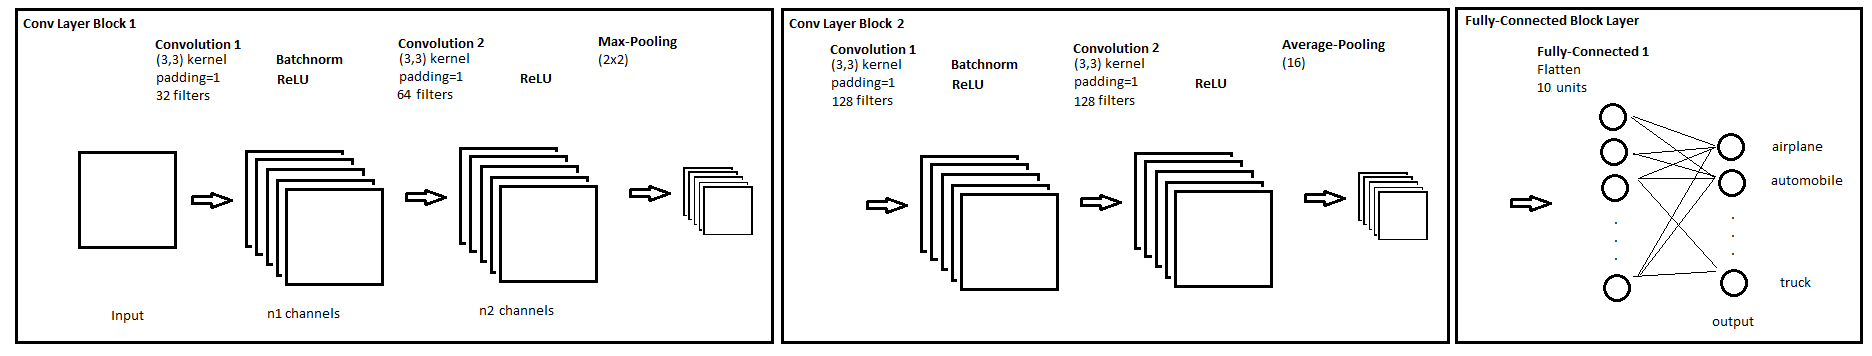

*   Convolutional layer 1: with 32 filters, kernel size of 3*3 and padding 1.
*   Batchnorm and ReLU layers
*   Convolutional layer 2: with 64 filters, kernel size of 3*3 and padding 1.
*   ReLU Activation layer
*   Max pooling with kernel size of 2*2
*   Convolutional layer 3: with 128 filters, kernel size of 3*3 and padding 1.
*   Batchnorm and ReLU layers
*   Convolutional layer 4: with 128 filters, kernel size of 3*3 and padding 1.
*   ReLU Activation layer
*   Average pooling with kernel size 16*16
*   Fully connected layer

#### **Questions**

- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?
 - Padding helps in controlling the spatial dimensions of the output feature map. Padding ensures that the convolution operation does not reduce the size of the feature map too quickly and that important edge information is not lost.
 - Valid padding = No padding
 - Same padding = Zero padding. The output features map has the same dimensions as the input feature map by adding zeros around borders.
 - Full padding = Increase the size of the output features map beyond the input size by adding more padding.
- What does padding=1 mean in the case of the network displayed above?
  - Padding=1 means that the size of the feature map is equal to the size of the original image (if stride=1).
- What are the dimensions of the feature maps after the 1. conv layer?
  - $$ 32*32*32 $$
- What are the dimensions of the feature maps after the 2. conv layer?
  - $$ 32*32*64 $$
  - after Max pool layer: $$ 16*16*64 $$
- What ist the receptive field size after the first two convolutions?
  - The receptive field is the region of the iput that each neuron in the convolutional layer is "sensitive to". In other words, it tells you how much of the original input image each neuron "sees" based on the filter sizes and strides used in the convolutions. As you apply more convolution layers, the receptive field grows, meaning that the neurons in higher layers "see" larger parts of the input image.
  - Formula for receptive field:
  $$ R_n = (R(n-1) - 1) * S_n + K_n $$
  R=receptive field, S=stride size, K=kernel size
  as a result the receptive field in the first convolution is sipmly kernel size: $$3*3$$
  in the second convolution it is:
  $$ (3-1)*1 + 3 = 5 $$ -> $$ 5*5 $$
- What is the value for the in_features for the fully-connected layer?
  - $$ #in_features = 128 $$
- What is the number of parameters of *Conv Layer block 1*?
  - 896 params for the Conv1 and 64 params for the BatchNorm. Thus, the total is 960.

**Your answers here**

In [ ]:
#TODO: Define model 2
class ComplexCNN(nn.Module):
    def __init__(self):
        super(ComplexCNN, self).__init__()

        # Convolutional Layer 1: 3 -> 32 filters, 3x3 kernel, padding=1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization
        # Conv layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # Max Pool layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial dimensions by half
        # Conv layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch Normalization
        # Conv layer 4
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=16)  # Pooling over the entire feature map
        # Fully connected layer
        self.fc = nn.Linear(128, 10)  # 10 output classes (CIFAR-10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # Conv1 -> BN -> ReLU
        x = F.relu(self.conv2(x))  # Conv2 -> ReLU
        x = self.pool(x)  # Max Pooling

        x = F.relu(self.bn3(self.conv3(x)))  # Conv3 -> BN -> ReLU
        x = F.relu(self.conv4(x))  # Conv4 -> ReLU
        x = self.pool2(x)  # Global Average Pooling
        x = x.view(x.size(0), -1)  # Flatten feature maps
        x = self.fc(x)  # Fully connected layer

        return x

# Instantiate model
model = ComplexCNN()

In [ ]:
from torchsummary import summary

model = ComplexCNN().to("cuda")  # Move model to CPU
summary(model, input_size=(3, 32, 32))  # CIFAR-10 input size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 64, 32, 32]          18,496
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
            Conv2d-7          [-1, 128, 16, 16]         147,584
         AvgPool2d-8            [-1, 128, 1, 1]               0
            Linear-9                   [-1, 10]           1,290
Total params: 242,442
Trainable params: 242,442
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.88
Params size (MB): 0.92
Estimated Total Size (MB): 2.81
-------------------------------------------

#### **TODO**

- train the new net (30 epochs, try lr=0.1 or change as necessary), plot the results, and compare the results to the 1-layer CNN
- explain why you observe these results

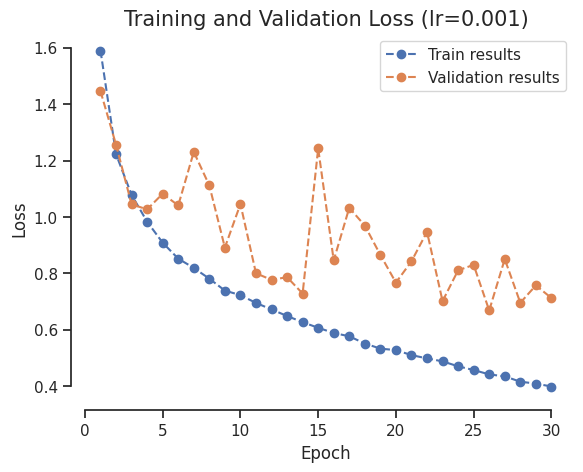

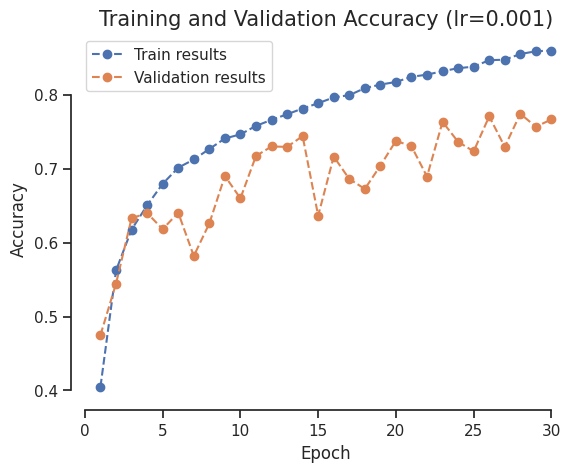

In [ ]:
# TODO: Train and plot
model = ComplexCNN().to(device)  # Move model to GPU if available

# Define optimizer and loss function
lr = 0.001  # Learning rate
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train the model for 30 epochs
num_epochs = 30
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
    model, optimizer, loss_function, device, num_epochs, train_loader, val_loader, verbose=True)

# Plot learning and accuracy curves
my_setup.plot(
    title=f"Training and Validation Loss (lr={lr})",
    label="Loss",
    train_results=train_losses,
    val_results=val_losses,
    yscale='linear')

my_setup.plot(
    title=f"Training and Validation Accuracy (lr={lr})",
    label="Accuracy",
    train_results=train_accs,
    val_results=val_accs,
    yscale='linear')

## 5. ResNet architecture

"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]

That was the intention of He et al. to develop residual networks.

A ResNet is built of blocks which are called the *Residual Blocks*.
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

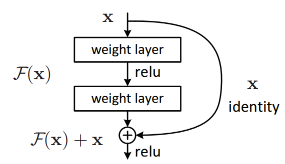

#### **Questions**
- Which problems do using skip connections solve?
  - Skip connections help to mitigate the vanishing gradient problem, which occurs when gradients become very small during backpropagation, making it difficult to train deep networks. They also help to improve the flow of information and gradients through the network, allowing for better training of deeper networks.
- Why is a residual network called residual?
  - A residual network is called residual because it uses residual blocks, which are designed to learn the residual (difference) between the input and the output of the block. Instead of learning the direct mapping, the network learns the residual mapping, which makes it easier to optimize and train deeper networks.

**Your answers here**

#### **TODO**
- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet
- write a class **ResNet(nn.Module)** where you define the model
- Train the model and plot results
- Train another model by disable residual connections and compare performance

*italicized text*![resnet_copy.jpg](attachment:469eb159-8c38-403c-af7c-21fd87465853.jpg)

**Hints**

- The downsampling in this ResNet happens between layer 1 and layer 2. In this step, the channel size is increased (32 -> 64) and the image resolution is downsampled by strided convolution (stride=2 in the Conv2d layers).
- For the adding part, the dimensions obviously have to be the same. This is accomplished by using stride=2 in the first Conv2d layer of the block while the second layer does not change the dimensions.
- The average-pooling layer has kernel size 7.
- For you to ensure everything works fine, here are the shapes in the form [(batchsize), x, y, channel] where I discard batchsize, because it does not change.
32x32x3 -> conv 7x7 -> 14x14x32 -> layer 1 -> 14x14x32 -> layer2 -> 7x7x64 -> avpool(7) -> 1x1x64 -> linear(64, 10)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # First conv: Downsampling when stride=2
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second conv: Keeps spatial dimensions unchanged
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection: Downsample only if in_channels != out_channels or stride = 2
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)  # Downsample input if needed
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity  # Add shortcut connection
        out = F.relu(out)

        return out


In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()

        # Initial Conv Layer (7x7 kernel, stride=2)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        # Layer 1: Two Residual Blocks (No downsampling, keep 32 channels)
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 32, stride=1),
            ResidualBlock(32, 32, stride=1)
        )

        # Layer 2: Two Residual Blocks (Downsample & Increase 32 -> 64 channels)
        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64, stride=2),  # Downsampling occurs here
            ResidualBlock(64, 64, stride=1)   # No downsampling
        )

        # Average Pooling Layer (7x7 kernel)
        self.avgpool = nn.AvgPool2d(kernel_size=7)

        # Fully Connected Layer (Flatten to 10 classes)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # Initial Conv + BatchNorm + ReLU
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        # Pass through Residual Blocks
        x = self.layer1(x)
        x = self.layer2(x)

        # Global Average Pooling (7x7 -> 1x1)
        x = self.avgpool(x)

        # Flatten for FC layer
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

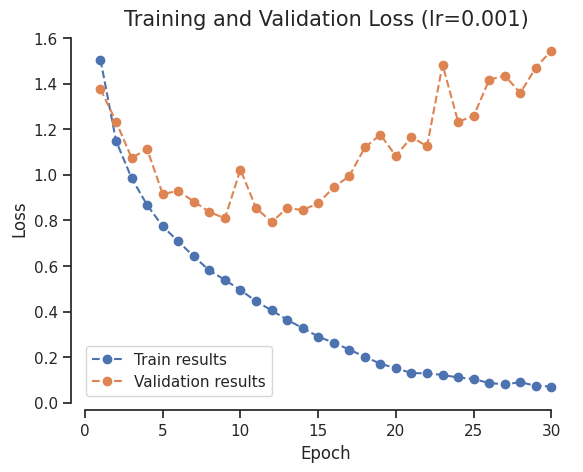

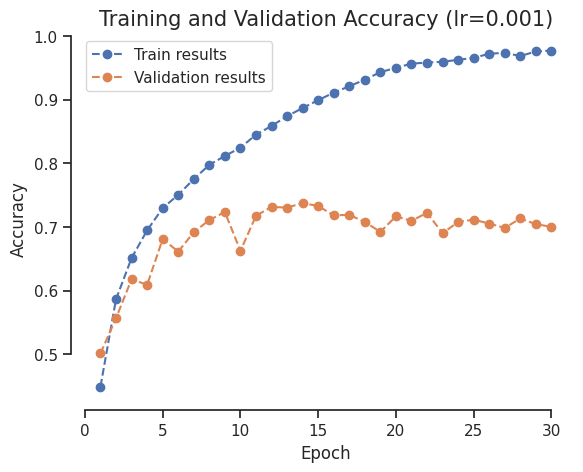

In [ ]:
# TODO: Train ResNet using the architecture laid out in the comments and figures above. Plot loss and accuracy for training and validation set.
model = ResNet().to(device)  # Move model to GPU if available

# Define optimizer and loss function
lr = 0.001  # Learning rate
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train the model for 30 epochs
num_epochs = 30
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
    model, optimizer, loss_function, device, num_epochs, train_loader, val_loader, verbose=True)

# Plot learning and accuracy curves
my_setup.plot(
    title=f"Training and Validation Loss (lr={lr})",
    label="Loss",
    train_results=train_losses,
    val_results=val_losses,
    yscale='linear')

my_setup.plot(
    title=f"Training and Validation Accuracy (lr={lr})",
    label="Accuracy",
    train_results=train_accs,
    val_results=val_accs,
    yscale='linear')

In [ ]:
# TODO: Train another model by disabling all residual connections. Plot loss and accuracy curves for training and validation set.
class NonResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(NonResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = self.relu(x)  # No shortcut connection!
        return x
class NonResidualResnet(nn.Module):
    def __init__(self, num_classes=10):
        super(NonResidualResnet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = nn.Sequential(
            NonResidualBlock(32, 32, stride=1),
            NonResidualBlock(32, 32, stride=1)
        )

        self.layer2 = nn.Sequential(
            NonResidualBlock(32, 64, stride=2),  # Downsampling happens here
            NonResidualBlock(64, 64, stride=1)
        )

        self.avgpool = nn.AvgPool2d(kernel_size=7)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


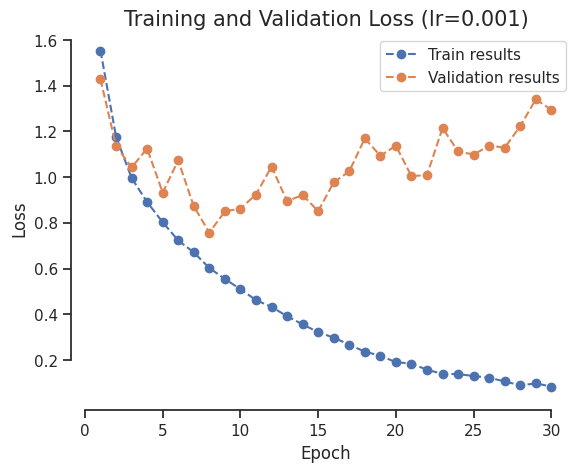

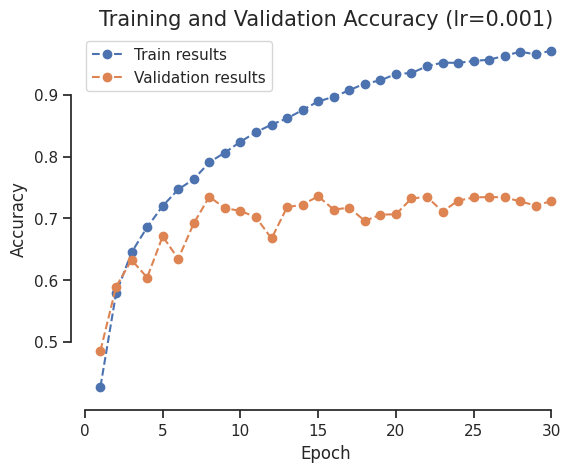

In [ ]:
# TODO: Train NonResidualResnet using the architecture laid out in the comments and figures above. Plot loss and accuracy for training and validation set.
model = NonResidualResnet().to(device)  # Move model to GPU if available

# Define optimizer and loss function
lr = 0.001  # Learning rate
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train the model for 30 epochs
num_epochs = 30
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
    model, optimizer, loss_function, device, num_epochs, train_loader, val_loader, verbose=True)

# Plot learning and accuracy curves
my_setup.plot(
    title=f"Training and Validation Loss (lr={lr})",
    label="Loss",
    train_results=train_losses,
    val_results=val_losses,
    yscale='linear')

my_setup.plot(
    title=f"Training and Validation Accuracy (lr={lr})",
    label="Accuracy",
    train_results=train_accs,
    val_results=val_accs,
    yscale='linear')

#### **Questions**
- Does using residual connections result in better performance in this exercise? If yes, why? If not, when would the benefit of using ResNet be most visible?
  - The results didn't improve. When can be due to several reasons: 1) Residual blocks show there effect especially in deep networks when model is more prone to the vanishing gradients problem. 2) Model did not have enough time to learn parameters. 3) Hyperparameters such as learning rate were not optimized.
- In deeper networks, how would you expect residual blocks to influence training time? why?
  - By enabling the efficient training of models residual blocks can facilitate faster convergence in neural networks. By providing shortcut connections that allow gradients to flow more easily through the network, residual blocks can help maintain strong gradient signals even in very deep networks. This can lead to faster convergence and more effective training, as the network can learn more efficiently and avoid getting stuck in local minima. Therefore, in deeper networks, residual blocks are expected to reduce training time and improve overall performance.
- Compare the performance and training time of your ResNet with the CNNs you trained in the previous section.

**Your answers here**

## 6. Explore Learning Rate Scheduling

Learning rate scheduling is a mechanism to adjust the learning rate.

*`torch.optim.lr_scheduler`* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**
- change run_training and extend to use scheduler for learning rate
- use `StepLR` (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.


#### **Questions**

- Try step size 1, gamma 0.1
    - How does it change the learning rate?
    - what do you observe regarding performance?
- Try step size 1, gamma 0.9, what do you observe?
    - How does it change the learning rate?
    - what do you observe regarding performance?
- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?

**Your answers here**

In [ ]:
# TODO: Change run_training (you can copy the code from setup.py here and create a new method here
# or just change/create a new method it in the python file)
def run_training(
    model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, scheduler=None, early_stopper=None, verbose=False):
    """
    Trains a given model using the specified optimizer, loss function, and dataloaders.

    Args:
        model: The PyTorch model to train.
        optimizer: The optimizer for weight updates.
        loss_function: Loss function used for training.
        device: Device to perform computations (CPU/GPU).
        num_epochs: Maximum number of training epochs.
        train_dataloader: Dataloader for training set.
        val_dataloader: Dataloader for validation set.
        scheduler: Learning rate scheduler. Defaults to None.
        early_stopper: Early stopping mechanism. Defaults to None.
        verbose: Whether to print training progress. Defaults to False.

    Returns:
        tuple: Lists of training losses, validation losses, training accuracies, validation accuracies per epoch,
               and the final confusion matrix.
    """
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(
            train_dataloader, optimizer, model, loss_function, device, master_bar)

        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(
            val_dataloader, model, loss_function, device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)

        # Adjust learning rate if scheduler is provided
        if scheduler:
            scheduler.step()

        # Print information about training progress
        if verbose:
            master_bar.write(f'Epoch {epoch+1}/{num_epochs}: '
                             f'Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, '
                             f'Train Acc: {epoch_train_acc:.2f}, Val Acc: {epoch_val_acc:.2f}, '
                             f'LR: {scheduler.get_last_lr()[0]:.6f}' if scheduler else '')

        # Check if early stopping should be applied
        if early_stopper:
            early_stopper(epoch_val_loss, model)
            if early_stopper.early_stop:
                print("Early stopping triggered. Training stopped.")
                break

    return train_losses, val_losses, train_accs, val_accs, confusion_matrix

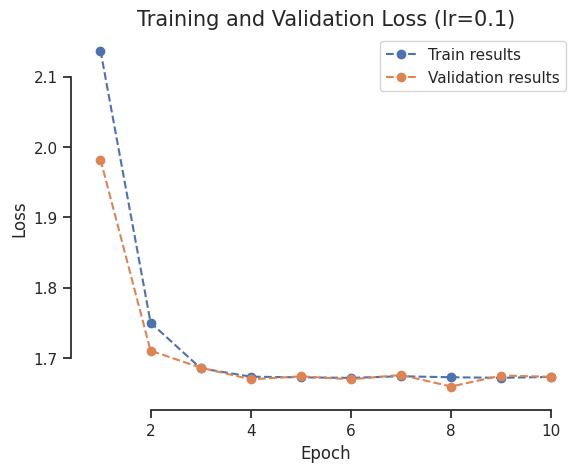

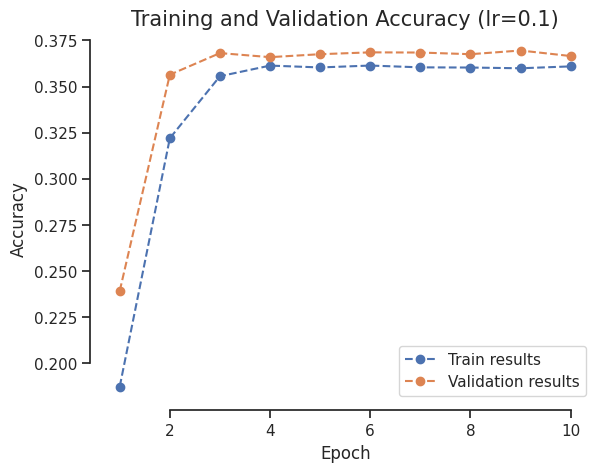

In [ ]:
# TODO: Train and plot with step size 1, gamma 0.1
model = ResNet().to(device)  # Move model to GPU if available

# Define optimizer and loss function
lr = 0.1
optimizer = optim.Adam(model.parameters(), lr=lr)

# Define StepLR scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)  # Reduce LR every 1 epoch

# Train the model for 10 epochs
num_epochs = 10
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
    model, optimizer, loss_function, device, num_epochs, train_loader, val_loader, scheduler=scheduler, verbose=True
)

# Plot learning and accuracy curves
my_setup.plot(
    title=f"Training and Validation Loss (lr={lr})",
    label="Loss",
    train_results=train_losses,
    val_results=val_losses,
    yscale='linear')

my_setup.plot(
    title=f"Training and Validation Accuracy (lr={lr})",
    label="Accuracy",
    train_results=train_accs,
    val_results=val_accs,
    yscale='linear')

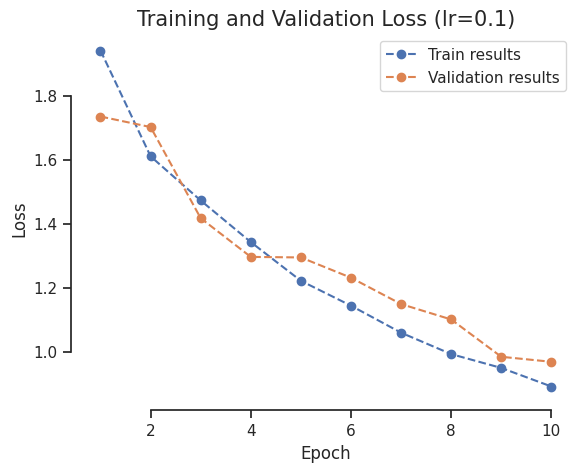

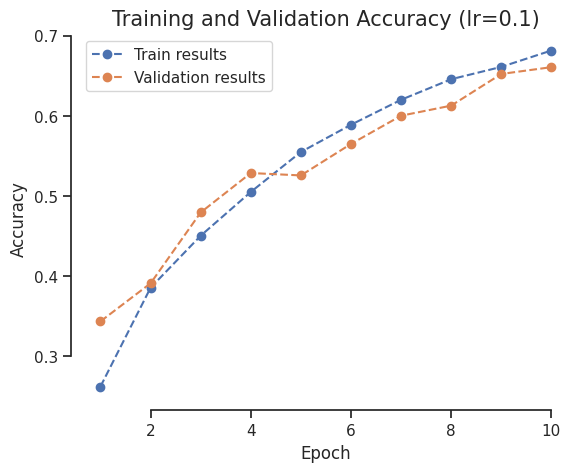

In [ ]:
# TODO: Train and plot with step size 1, gamma 0.9
model = ResNet().to(device)  # Move model to GPU if available

# Define optimizer and loss function
lr = 0.1
optimizer = optim.Adam(model.parameters(), lr=lr)

# Define StepLR scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)  # Reduce LR every 1 epoch

# Train the model for 10 epochs
num_epochs = 10
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
    model, optimizer, loss_function, device, num_epochs, train_loader, val_loader, scheduler=scheduler, verbose=True
)

# Plot learning and accuracy curves
my_setup.plot(
    title=f"Training and Validation Loss (lr={lr})",
    label="Loss",
    train_results=train_losses,
    val_results=val_losses,
    yscale='linear')

my_setup.plot(
    title=f"Training and Validation Accuracy (lr={lr})",
    label="Accuracy",
    train_results=train_accs,
    val_results=val_accs,
    yscale='linear')

#### **TODO**

Use step size 15, gamma 0.1. Train for 30 epochs.

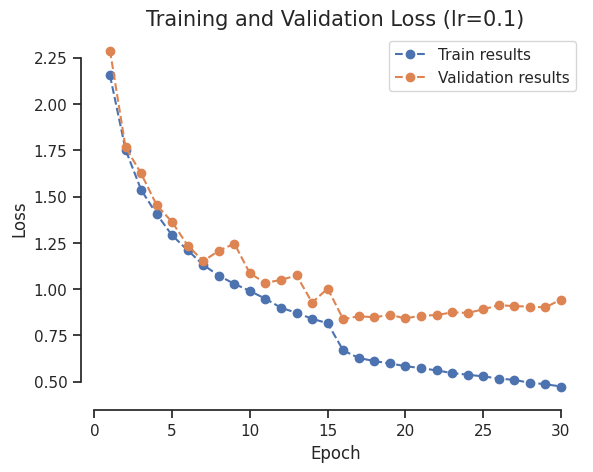

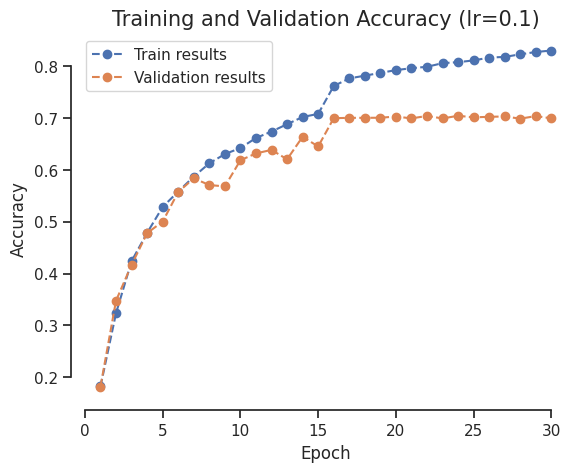

In [ ]:
# TODO: Train and plot with step size 15, gamma 0.1, 30 epochs.
model = ResNet().to(device)  # Move model to GPU if available

# Define optimizer and loss function
lr = 0.1
optimizer = optim.Adam(model.parameters(), lr=lr)

# Define StepLR scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)  # Reduce LR every 15 epoch

# Train the model for 30 epochs
num_epochs = 30
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
    model, optimizer, loss_function, device, num_epochs, train_loader, val_loader, scheduler=scheduler, verbose=True
)

# Plot learning and accuracy curves
my_setup.plot(
    title=f"Training and Validation Loss (lr={lr})",
    label="Loss",
    train_results=train_losses,
    val_results=val_losses,
    yscale='linear')

my_setup.plot(
    title=f"Training and Validation Accuracy (lr={lr})",
    label="Accuracy",
    train_results=train_accs,
    val_results=val_accs,
    yscale='linear')

#### **Questions**
- Does it improve performance?
  - Using different values of step_size and gamma for the `stepLR` by far the step_size=1 and gamma=0.9 has the best results after 10 epochs. Starting LR=0.1
- What can you observe in the plots?
  - That the overfitting rate deacreases and models learn patterns much faster.

**Your answers here**

## 7. LR-Scheduling _(Optional)_

#### TODO _(Optional)_
- try two more scheduler: ExponentialLR and ReduceLROnPlateau
- vary the parameters, which work best?
- does it improve performance compared to no scheduler?
- does it improve performance compared to StepLR?

In [ ]:
# TODO (Optional): Train and plot with different schedulers
# TODO: Change run_training (you can copy the code from setup.py here and create a new method here
# or just change/create a new method it in the python file)
def run_training(
    model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, scheduler=None, early_stopper=None, verbose=False):
    """
    Trains a given model using the specified optimizer, loss function, and dataloaders.

    Args:
        model: The PyTorch model to train.
        optimizer: The optimizer for weight updates.
        loss_function: Loss function used for training.
        device: Device to perform computations (CPU/GPU).
        num_epochs: Maximum number of training epochs.
        train_dataloader: Dataloader for training set.
        val_dataloader: Dataloader for validation set.
        scheduler: Learning rate scheduler. Defaults to None.
        early_stopper: Early stopping mechanism. Defaults to None.
        verbose: Whether to print training progress. Defaults to False.

    Returns:
        tuple: Lists of training losses, validation losses, training accuracies, validation accuracies per epoch,
               and the final confusion matrix.
    """
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(
            train_dataloader, optimizer, model, loss_function, device, master_bar)

        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(
            val_dataloader, model, loss_function, device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)

        # Adjust learning rate based on the scheduler type
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_val_loss)    # Reduce based on the validation loss
            else:
                scheduler.step()    # StepLR and ExponentialLR

        # Print information about training progress
        if verbose:
            current_lr = optimizer.param_groups[0]['lr']
            master_bar.write(f"Epoch {epoch+1}/{num_epochs}: |"
                             f'Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, '
                             f'Train Acc: {epoch_train_acc:.2f}, Val Acc: {epoch_val_acc:.2f}, '
                             f'LR: {current_lr:.6f}')

        # Check if early stopping should be applied
        if early_stopper:
            early_stopper(epoch_val_loss, model)
            if early_stopper.early_stop:
                print("Early stopping triggered. Training stopped.")
                break

    return train_losses, val_losses, train_accs, val_accs, confusion_matrix


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


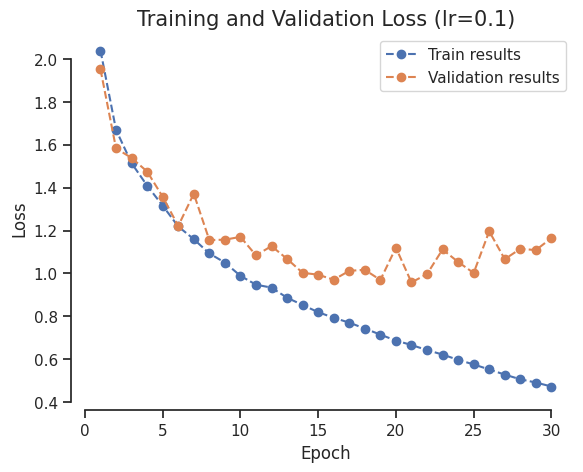

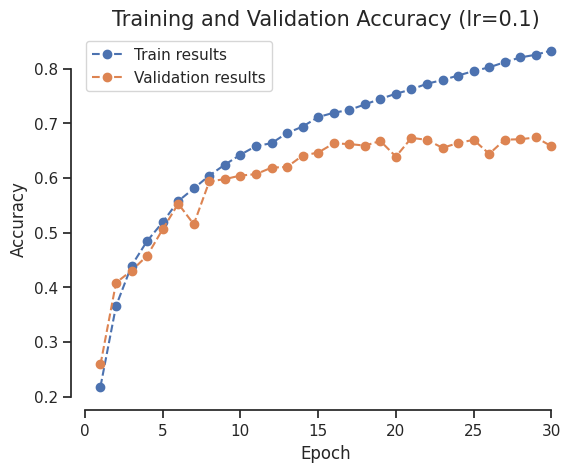

In [ ]:
# TODO: Train and plot with gamma 0.95, 30 epochs.
model = ResNet().to(device)  # Move model to GPU if available

# Define optimizer and loss function
lr = 0.1
optimizer = optim.Adam(model.parameters(), lr=lr)

# Define StepLR scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)  # Mulply learning rate by 0.95 every epoch

# Train the model for 30 epochs
num_epochs = 30
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
    model, optimizer, loss_function, device, num_epochs, train_loader, val_loader, scheduler=scheduler, verbose=True
)

# Plot learning and accuracy curves
my_setup.plot(
    title=f"Training and Validation Loss (lr={lr})",
    label="Loss",
    train_results=train_losses,
    val_results=val_losses,
    yscale='linear')

my_setup.plot(
    title=f"Training and Validation Accuracy (lr={lr})",
    label="Accuracy",
    train_results=train_accs,
    val_results=val_accs,
    yscale='linear')

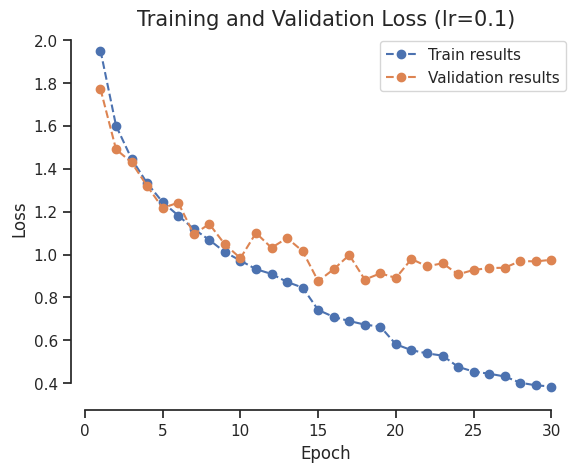

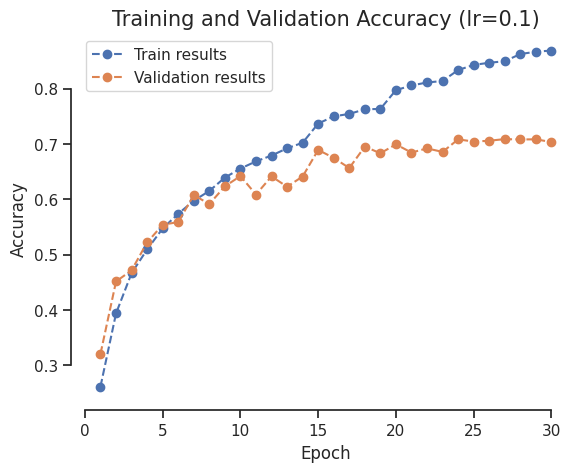

In [ ]:
# TODO: Train and plot with gamma 0.95, 30 epochs.
model = ResNet().to(device)  # Move model to GPU if available

# Define optimizer and loss function
lr = 0.1
optimizer = optim.Adam(model.parameters(), lr=lr)

# Define StepLR scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)  # Reduce LR by 50% if validation loss does not improve for 3 epochs

# Train the model for 30 epochs
num_epochs = 30
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
    model, optimizer, loss_function, device, num_epochs, train_loader, val_loader, scheduler=scheduler, verbose=True
)

# Plot learning and accuracy curves
my_setup.plot(
    title=f"Training and Validation Loss (lr={lr})",
    label="Loss",
    train_results=train_losses,
    val_results=val_losses,
    yscale='linear')

my_setup.plot(
    title=f"Training and Validation Accuracy (lr={lr})",
    label="Accuracy",
    train_results=train_accs,
    val_results=val_accs,
    yscale='linear')

**Your answers here**